# HSLS Data Analysis: Modeling Mathematical Proficiency and High School GPA by Environmental and Socioeconomic Factors
- UrsaTech Jupyter Notebook
- 25 November 2020
- By Barnett Yang

## Table of Contents
* [Goals](#goals)
* [Miscellaneous Notes and Libraries](#notes)
* [Indicators and Relevant Variables](#vars)
* [Modeling the Data Using Linear Regression and Neural Networks](#model)
* [ANOVA Testing: Measuring Variance of Math Theta Scores By Poverty and Income](#anova)
* [Conclusions](#conclusions)

## Goals<a id="goals"></a>
1. Model mathematical proficiency by environmental and socioeconomic variables without looking at academic indicators.
2. ANOVA test mathematics theta scores by poverty and income.

## Miscellaneous Notes and Libraries<a id='notes'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing

import statsmodels.api as sm
from statsmodels.formula.api import ols

sns.set(rc={'figure.figsize':(15, 7)})
sns.set_context("paper", font_scale=1.8)

## Indicators and Relevant Variables<a id='vars'></a>

### Relevant Academic Success Indicators
- X2TXMTH: Mathematics theta score in first follow-up. 
    - Measured relative to the population as a whole.
    - Norm-referenced measure of achievement. 
    - Min: -8, Max: 4.5046, Mean: -0.3623, Std: 3.0663.
- X2TXMSCR: Mathematics IRT-estimated number right score. 
    - 2009 9th graders.
    - Min: -8, Max: 115.1, Mean: 57.9116, Std: 30.6156.
- X2TXMQUINT: Mathematics quintile score. 
    - 1 (lowest) to 5 (highest).
    - Note: Remove unit non-response (-8).
    - Based off of base year 2009 Mathematics Assessment of Algebraic Reasoning. See section 2.3 of https://nces.ed.gov/pubs2014/2014361.pdf for details.
- X3TGPAWGT: Overall GPA computed, honors-weighted.
    
### Sex, Race, Family Income, Poverty Level Variables
- X1SEX: Student Sex.
    - 1: Male
    - 2: Female
- X1RACE: Student Race. 
    - 1: American Indian/Alaska Native 
    - 2: Asian
    - 3: Black/African-American
    - 4: Hispanic, no race specified
    - 5: Hispanic, race specified
    - 7: Native Hawaiian/Pacific Islander
    - 8: White
- X2FAMINCOME: Total family income from all sources (in US dollars, 2011). 
    - 1: <= 15000
    - 2: > 15000 and <= 35000
    - 3: > 35,000 and <= 55,000
    - 4: > 55,000 and <= 75,000
    - 5: > 75,000 and <= 95,000
    - 6: > 95,000 and <= 115,000
    - 7: > 115,000 and <= 135,000
    - 8: > 135,000 and <= 155,000
    - 9: > 155,000 and <= 175,000
    - 10: > 175,000 and <= 195,000
    - 11: > 195,000 and <= 215,000
    - 12: > 215,000 and <= 235,000
    - 13: > 235,000; 
    - -8: Unit non-response
- X2POVERTY: X2 Poverty indicator.
    - Relative to 100% of Census poverty threshold. 
    - 0: At or above poverty threshold
    - 1: Below poverty threshold
    - Note: Remove Unit non-response (-8).
- X1DADEDU: Father's/male guardian's highest level of education.
    - 0: No bio/adoptive/step-father in household
    - 1: Less than high school
    - 2: High school deploma or GED
    - 3: Associate's degree
    - 4: Bachelor's degree
    - 5: Master's degree
    - 7: Ph.D/M.D/Law/other high lvl prof degree
    - -9: Missing
    - -8: Unit non-response
- X1MOMEDU: Mother's/female guardian's highest level of education.
    - 0: No bio/adoptive/step-mother in household
    - 1: Less than high school
    - 2: High school deploma or GED
    - 3: Associate's degree
    - 4: Bachelor's degree
    - 5: Master's degree
    - 7: Ph.D/M.D/Law/other high lvl prof degree
    - -9: Missing
    - -8: Unit non-response
- X2SES_U: Socio-economic status composite derived with locale (urbanicity).
    - Constructed using parent/guardians' education, occupation, family income, and school urbancity
- X2MTHID: Scale of studen'ts mathematics identity.
- X2HHNUMBER: Number of 2012 household members.
- X1SCHOOLENG: Scale of student's school engagement.
- X1SCHOOLBEL: Scale of student's sense of school belonging.

## Modeling the Data Using Linear Regression and Neural Networks<a id='model'></a>

### Constants and Load Data

In [2]:
variables = ['X2POVERTY', 'X2FAMINCOME', 'X1RACE', 'X1SEX', 'X2SES_U', 'X2MTHID', 'X2HHNUMBER', 'X1DADEDU', 'X1MOMEDU', 
             'X1SCHOOLENG', 'X1SCHOOLBEL', 'X2TXMTH']
data = pd.read_csv('../data/HSLS_2017_Datasets/hsls_17_student.csv', usecols=variables)

# Filter out non-respondants
data = data[(data['X2POVERTY'] >= 0) & (data['X2FAMINCOME'] > 0) & (data['X1RACE'] > 0) & 
            (data['X2SES_U'] > -8.0000) & (data['X2MTHID'] > -8.0000) & (data['X2HHNUMBER'] > 0) & 
            (data['X1DADEDU'] > 0) & (data['X1MOMEDU'] > 0) & (data['X1SCHOOLENG'] > -8.0000) & 
            (data['X1SCHOOLBEL'] > -8.0000) & (data['X1SEX'] > 0) & 
            (data['X2TXMTH'] > -8.0000)]

# Quickly one-hot encode sex
data['X1SEX'] = data['X1SEX'] - 1

In [3]:
data.head()

,X1SEX,X1RACE,X1MOMEDU,X1DADEDU,X1SCHOOLBEL,X1SCHOOLENG,X2TXMTH,X2HHNUMBER,X2FAMINCOME,X2POVERTY,X2SES_U,X2MTHID
0,0,8,5,5,0.84,-1.41,2.6606,4,11,0,1.6792,0.16
1,1,8,3,2,0.05,-0.20,1.0097,6,3,0,-0.3234,-0.42
5,1,8,3,3,-0.52,0.96,0.9994,5,5,0,0.0074,1.82
7,0,8,5,7,0.45,-0.20,1.9987,2,7,0,0.7948,0.70
8,0,8,2,2,0.11,0.10,1.6591,4,6,0,0.2285,0.70


### Processing Data Set

In [4]:
# One hot encode race
race_dummies = pd.get_dummies(data['X1RACE'].astype(str))
race_dummies = race_dummies.rename(columns={"1": "American Indian/Alaska Native", "2": "Asian", 
                                            "3": "Black/African-American", "4": "Hispanic, no race specified",
                                            "5": "Hispanic, race specified", "6": "More than one race",
                                            "7": "Native hawaiian/Pacific Islander", "8": "White"})

data_edit_dum = pd.concat([data, race_dummies], axis="columns").drop(columns="X1RACE")
data_edit_dum.describe()

,X1SEX,X1MOMEDU,X1DADEDU,X1SCHOOLBEL,X1SCHOOLENG,X2TXMTH,X2HHNUMBER,X2FAMINCOME,X2POVERTY,X2SES_U,X2MTHID,American Indian/Alaska Native,Asian,Black/African-American,"Hispanic, no race specified","Hispanic, race specified",More than one race,Native hawaiian/Pacific Islander,White
count,10477.000000,10477.000000,10477.000000,10477.000000,10477.000000,10477.000000,10477.000000,10477.000000,10477.000000,10477.000000,10477.000000,10477.000000,10477.000000,10477.000000,10477.000000,10477.000000,10477.000000,10477.000000,10477.000000
mean,0.501957,3.067577,3.114727,0.195138,0.183395,0.972076,4.373867,5.384557,0.106996,0.266163,0.118871,0.005727,0.086761,0.061850,0.004677,0.144412,0.079603,0.004486,0.612484
std,0.500020,1.346802,1.547766,0.952141,0.934146,1.135274,1.377094,3.180362,0.309123,0.756144,1.018759,0.075462,0.281499,0.240894,0.068231,0.351523,0.270690,0.066831,0.487206
min,0.000000,1.000000,1.000000,-4.350000,-3.380000,-2.601900,2.000000,1.000000,0.000000,-1.892400,-1.540000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,2.000000,-0.390000,-0.280000,0.295600,3.000000,3.000000,0.000000,-0.324100,-0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,3.000000,3.000000,0.160000,0.290000,0.914300,4.000000,5.000000,0.000000,0.248500,0.160000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,4.000000,4.000000,1.000000,1.010000,1.887800,5.000000,7.000000,0.000000,0.843000,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,7.000000,7.000000,1.590000,1.390000,4.504600,11.000000,13.000000,1.000000,2.661700,1.820000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Training the Model: Linear Regression and Ordinary Least Squares

In [5]:
#set up X (features) & y (target/response)
X1 = data_edit_dum.drop(columns='X2TXMTH')
X1 = X1.values

y1 = data_edit_dum['X2TXMTH']
y1 = y1.values

In [6]:
#test size = 0.25 which is default of sklearn, shuffle = False
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25, shuffle=False)
linreg1 = LinearRegression()
linreg1.fit(X1_train, y1_train)
linreg1_predictions = linreg1.predict(X1_test)
linreg1_mse = mean_squared_error(y1_test, linreg1_predictions)
linreg1_mae = mean_absolute_error(y1_test, linreg1_predictions)
print(linreg1_mse)
print(linreg1_mae)
print(linreg1.coef_)

0.8021285920375467
0.7176493268226993
[-2.86751180e-02  8.18457980e-02  1.23520240e-01  6.15632118e-02
  6.88543571e-02  3.26163427e-04  2.22819788e-02 -1.02563759e-01
  1.00279442e-01  4.12596288e-01 -2.37981106e-01  5.59265926e-01
 -3.36081484e-01 -1.15909898e-01 -2.56199005e-02  1.11120952e-01
 -2.28445197e-02  6.80500286e-02]


### Training the Model: Neural Network

In [7]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X1))

nn1 = keras.Sequential([
    normalizer,
    keras.layers.Dense(64, activation='sigmoid'),
    keras.layers.Dense(64, activation='sigmoid'),
    keras.layers.Dense(1)
])

nn1.compile(
    loss='mean_absolute_error', 
    optimizer=tf.keras.optimizers.Adam(0.001)
)

nn1_history = nn1.fit(X1_train, y1_train, epochs=50, verbose=0)

In [8]:
nn1_predictions = nn1.predict(X1_test)
nn1_mse = mean_squared_error(y1_test, nn1_predictions)
nn1_mae = mean_absolute_error(y1_test, nn1_predictions)
print(nn1_mse)
print(nn1_mae)

0.8033472627163533
0.710586606605409


## ANOVA Testing: Measuring Variance of Math Theta Scores By Poverty and Income<a id='anova'></a>

In [9]:
math_poverty = pd.read_csv('../data/HSLS_2017_Datasets/hsls_17_student.csv', usecols=['X2POVERTY', 'X2TXMTH'])
math_poverty = math_poverty[(math_poverty['X2POVERTY'] >= 0) & (math_poverty['X2TXMTH'] > -8.0000)]

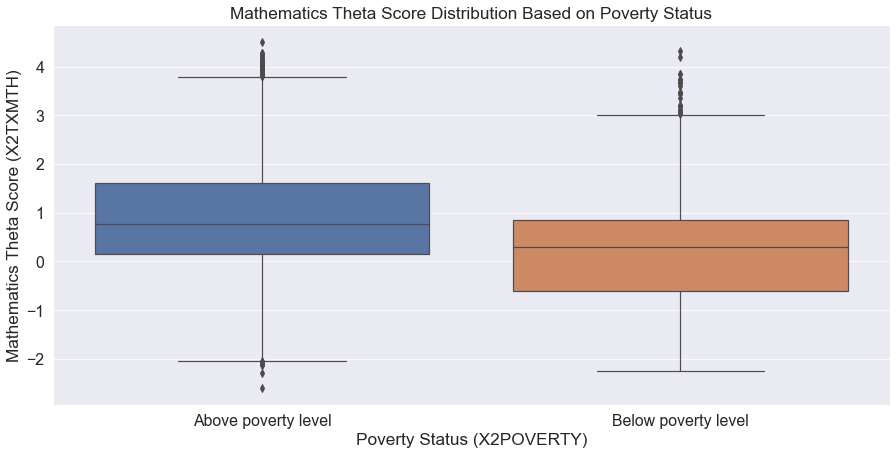

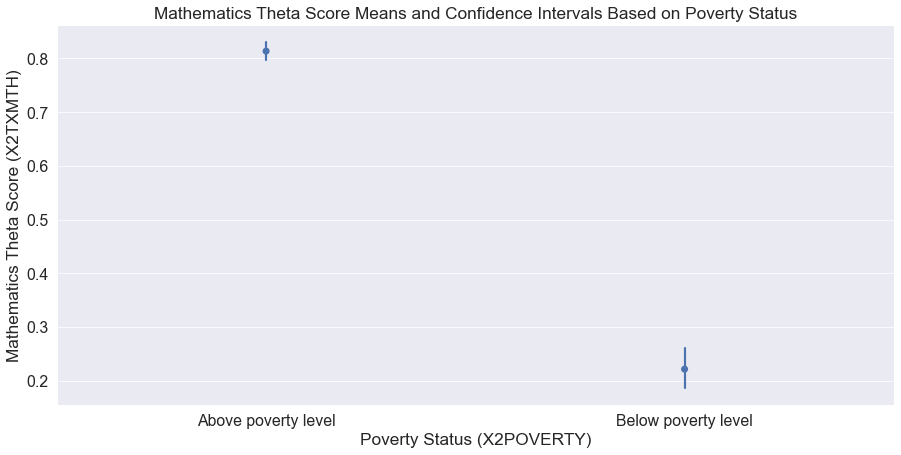

In [10]:
plt.figure()
math_poverty_boxplot = sns.boxplot(x="X2POVERTY", y="X2TXMTH", data=math_poverty)
math_poverty_boxplot.set(ylabel="Mathematics Theta Score (X2TXMTH)", xlabel="Poverty Status (X2POVERTY)")
math_poverty_boxplot.set_xticklabels(["Above poverty level", "Below poverty level"])
math_poverty_boxplot.set_title("Mathematics Theta Score Distribution Based on Poverty Status")
math_poverty_boxplot.get_figure().savefig("graphs/Mathematics_Theta_Score_Poverty_BoxPlot.png", dpi=400)

plt.figure()
math_poverty_pointplot = sns.pointplot(x="X2POVERTY", y="X2TXMTH", data=math_poverty, join=False)
math_poverty_pointplot.set(ylabel="Mathematics Theta Score (X2TXMTH)", xlabel="Poverty Status (X2POVERTY)")
math_poverty_pointplot.set_xticklabels(["Above poverty level", "Below poverty level"])
math_poverty_pointplot.set_title(
    "Mathematics Theta Score Means and Confidence Intervals Based on Poverty Status"
)
math_poverty_pointplot.get_figure().savefig("graphs/Mathematics_Theta_Score_Poverty_PointPlot.png", dpi=400)

In [11]:
math_poverty_str = math_poverty.copy()
math_poverty_str['X2POVERTY'] = math_poverty['X2POVERTY'].apply(str)
math_poverty_mod = ols('X2TXMTH ~ X2POVERTY', data=math_poverty_str).fit()
math_poverty_aov_table = sm.stats.anova_lm(math_poverty_mod, typ=2)
print(math_poverty_aov_table)

                 sum_sq       df           F         PR(>F)
X2POVERTY    987.871369      1.0  772.971973  4.899952e-167
Residual   26316.927301  20592.0         NaN            NaN


In [12]:
math_income = pd.read_csv('../data/HSLS_2017_Datasets/hsls_17_student.csv', usecols=['X2FAMINCOME', 'X2TXMTH'])
math_income = math_income[(math_income['X2FAMINCOME'] >= 0) & (math_income['X2TXMTH'] > -8.0000)]

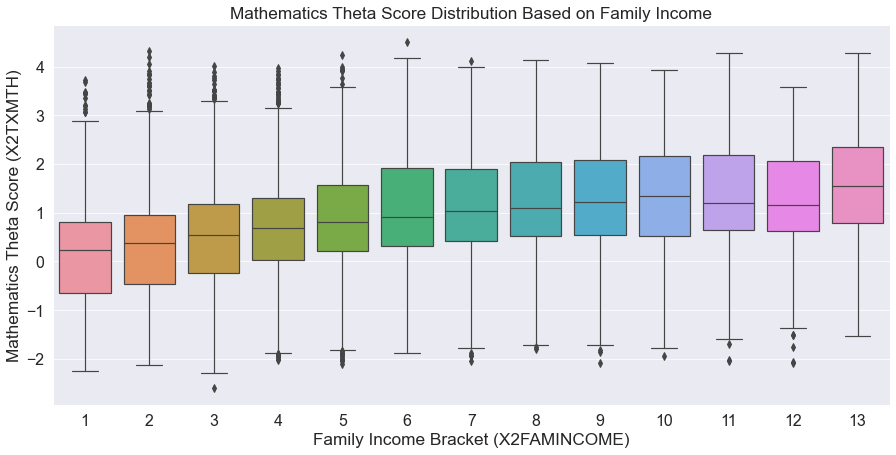

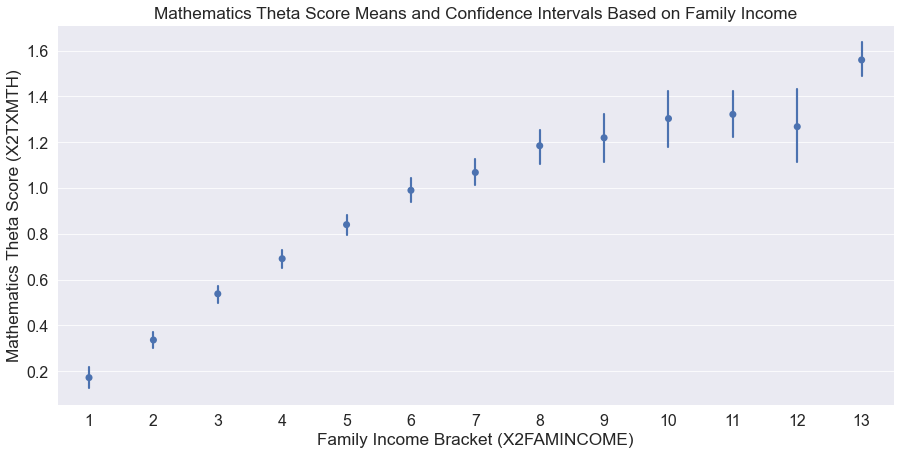

In [13]:
plt.figure()
math_income_boxplot = sns.boxplot(x="X2FAMINCOME", y="X2TXMTH", data=math_income)
math_income_boxplot.set(ylabel="Mathematics Theta Score (X2TXMTH)", xlabel="Family Income Bracket (X2FAMINCOME)")
math_income_boxplot.set_title("Mathematics Theta Score Distribution Based on Family Income")
math_income_boxplot.get_figure().savefig("graphs/Mathematics_Theta_Score_Income_BoxPlot.png", dpi=400)

plt.figure()
math_income_pointplot = sns.pointplot(x="X2FAMINCOME", y="X2TXMTH", data=math_income, join=False)
math_income_pointplot.set(ylabel="Mathematics Theta Score (X2TXMTH)", xlabel="Family Income Bracket (X2FAMINCOME)")
math_income_pointplot.set_title(
    "Mathematics Theta Score Means and Confidence Intervals Based on Family Income"
)
math_income_pointplot.get_figure().savefig("graphs/Mathematics_Theta_Score_Income_PointPlot.png", dpi=400)

In [14]:
math_income_str = math_income.copy()
math_income_str['X2FAMINCOME'] = math_income['X2FAMINCOME'].apply(str)
math_income['X2FAMINCOME'] = math_income['X2FAMINCOME'].apply(str)
math_income_mod = ols('X2TXMTH ~ X2FAMINCOME', data=math_income_str).fit()
math_income_aov_table = sm.stats.anova_lm(math_income_mod, typ=2)
print(math_income_aov_table)

                   sum_sq       df           F  PR(>F)
X2FAMINCOME   2833.967430     12.0  198.623833     0.0
Residual     24470.831239  20581.0         NaN     NaN


## ANOVA Testing: Measuring Variance of High School Honors-Weighted GPA By Poverty and Income

In [15]:
gpa_poverty = pd.read_csv('../data/HSLS_2017_Datasets/hsls_17_student.csv', usecols=['X2POVERTY', 'X3TGPAWGT'])
gpa_poverty = gpa_poverty[(gpa_poverty['X2POVERTY'] >= 0) & (gpa_poverty['X3TGPAWGT'] > -8.0000)]

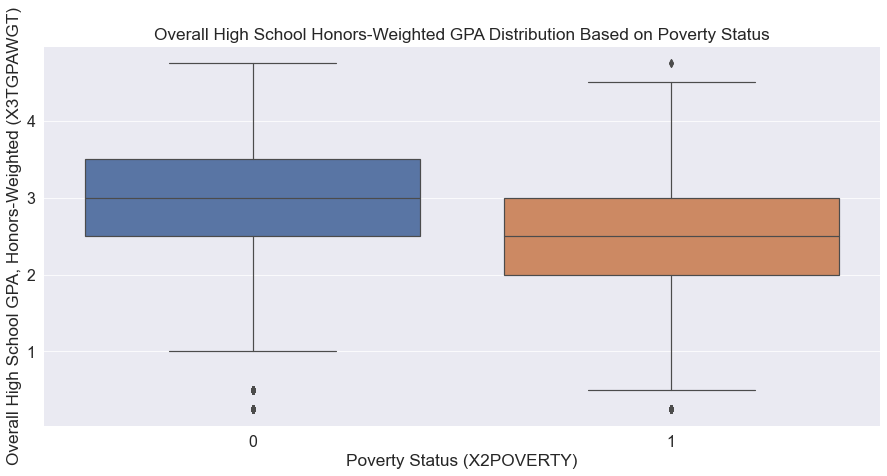

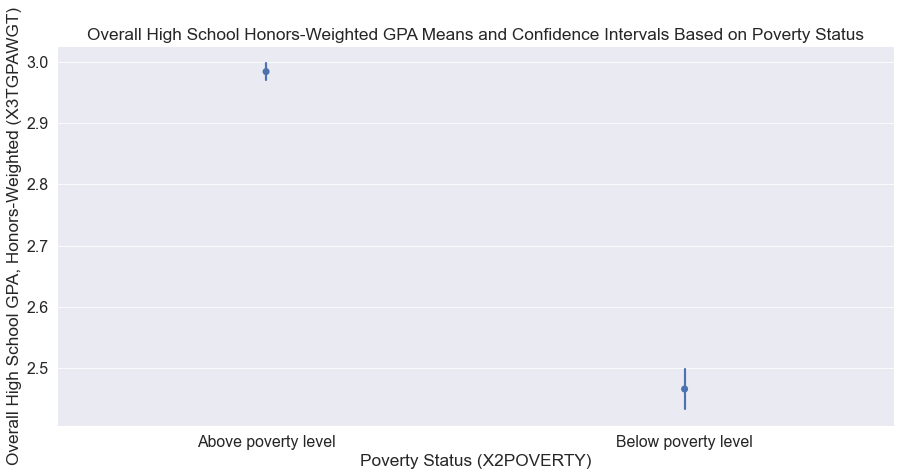

In [16]:
plt.figure()
gpa_poverty_boxplot = sns.boxplot(x="X2POVERTY", y="X3TGPAWGT", data=gpa_poverty)
gpa_poverty_boxplot.set(ylabel="Overall High School GPA, Honors-Weighted (X3TGPAWGT)", xlabel="Poverty Status (X2POVERTY)")
gpa_poverty_boxplot.set_title("Overall High School Honors-Weighted GPA Distribution Based on Poverty Status")
gpa_poverty_boxplot.get_figure().savefig("graphs/GPA_Poverty_BoxPlot.png", dpi=400)

plt.figure()
gpa_poverty_pointplot = sns.pointplot(x="X2POVERTY", y="X3TGPAWGT", data=gpa_poverty, join=False)
gpa_poverty_pointplot.set(ylabel="Overall High School GPA, Honors-Weighted (X3TGPAWGT)", xlabel="Poverty Status (X2POVERTY)")
gpa_poverty_pointplot.set_title(
    "Overall High School Honors-Weighted GPA Means and Confidence Intervals Based on Poverty Status"
)
gpa_poverty_pointplot.set_xticklabels(["Above poverty level", "Below poverty level"])
gpa_poverty_pointplot.get_figure().savefig("graphs/GPA_Poverty_PointPlot.png", dpi=400)

In [17]:
gpa_poverty_str = gpa_poverty.copy()
gpa_poverty_str['X2POVERTY'] = gpa_poverty['X2POVERTY'].apply(str)
gpa_poverty_mod = ols('X3TGPAWGT ~ X2POVERTY', data=gpa_poverty_str).fit()
gpa_poverty_aov_table = sm.stats.anova_lm(gpa_poverty_mod, typ=2)
print(gpa_poverty_aov_table)

                 sum_sq       df          F         PR(>F)
X2POVERTY    732.730336      1.0  899.82634  2.229521e-193
Residual   16126.435661  19804.0        NaN            NaN


In [18]:
gpa_income = pd.read_csv('../data/HSLS_2017_Datasets/hsls_17_student.csv', usecols=['X2FAMINCOME', 'X3TGPAWGT'])
gpa_income = gpa_income[(gpa_income['X2FAMINCOME'] >= 0) & (gpa_income['X3TGPAWGT'] > -8.0000)]

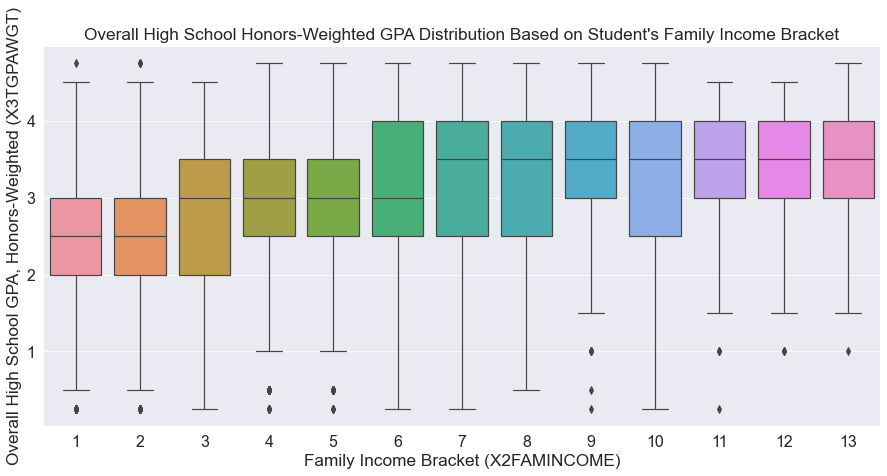

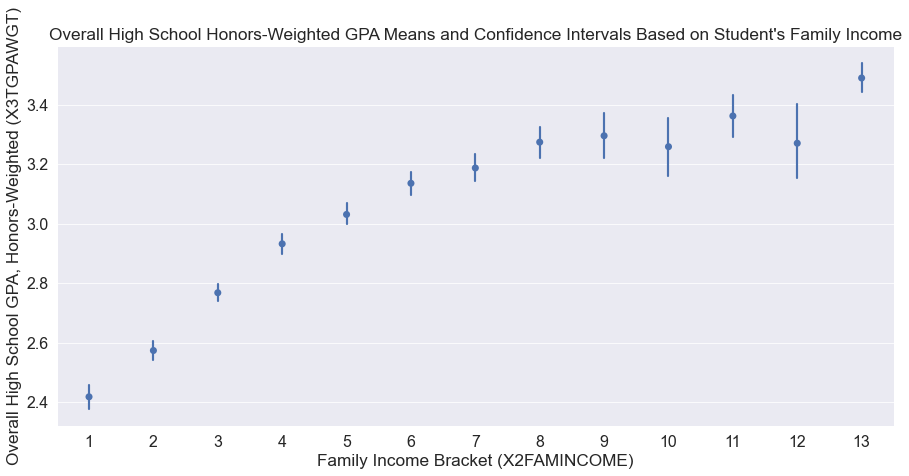

In [19]:
plt.figure()
gpa_income_boxplot = sns.boxplot(x="X2FAMINCOME", y="X3TGPAWGT", data=gpa_income)
gpa_income_boxplot.set(ylabel="Overall High School GPA, Honors-Weighted (X3TGPAWGT)", xlabel="Family Income Bracket (X2FAMINCOME)")
gpa_income_boxplot.set_title(
    "Overall High School Honors-Weighted GPA Distribution Based on Student's Family Income Bracket"
)
gpa_income_boxplot.get_figure().savefig("graphs/GPA_Income_BoxPlot.png", dpi=400)

plt.figure()
gpa_income_pointplot = sns.pointplot(x="X2FAMINCOME", y="X3TGPAWGT", data=gpa_income, join=False)
gpa_income_pointplot.set(ylabel="Overall High School GPA, Honors-Weighted (X3TGPAWGT)", xlabel="Family Income Bracket (X2FAMINCOME)")
gpa_income_pointplot.set_title(
    "Overall High School Honors-Weighted GPA Means and Confidence Intervals Based on Student's Family Income"
)
gpa_income_pointplot.get_figure().savefig("graphs/GPA_Income_PointPlot.png", dpi=400)

In [20]:
gpa_income_str = gpa_income.copy()
gpa_income_str['X2FAMINCOME'] = gpa_income['X2FAMINCOME'].apply(str)
gpa_income_mod = ols('X3TGPAWGT ~ X2FAMINCOME', data=gpa_income_str).fit()
gpa_income_aov_table = sm.stats.anova_lm(gpa_income_mod, typ=2)
print(gpa_income_aov_table)

                   sum_sq       df          F  PR(>F)
X2FAMINCOME   1753.831408     12.0  191.50842     0.0
Residual     15105.334589  19793.0        NaN     NaN


## Conclusions<a id='conclusions'></a>

### Modeling Mathematics Theta Scores by Socioeconomic and Environmental Factors
The neural network model was only marginally more successful at predicting test data than the linear regression model was. However, both models seemed relatively accurate with a mean squared error of approximately 0.8 with a data range of 7. More accurate predictions may require a greater number of variables to feed into the models.

### ANOVA Testing: Measuring Variance of Mathematics Theta Scores By Poverty and Income
The p-values for both poverty and income are extremely low, indicating that we can reject the null hypothesis and that poverty and income have significant impacts on students' mathematics theta scores and overall mathematics proficiency.